<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Getting Started with EarthDaily
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #EarthDailyConstellation, #EDC, #Sentinel-2, #VENuS, #Landsat, #STAC, #ODC

**Authors**: EarthDaily Analytics

**Last update:** 2024-02-11 (Created: 2024-12-17)

**References:**
- [EarthDaily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)

## Introduction
EarthDaily Analytics offers access to several [STAC-compliant](https://stacspec.org/en) catalogs of raster data, such as [EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) and [VENuS](https://earthdaily.com/earthdaily-ven%C2%B5s-l2a-cloud-optimized-geotiffs/), as well as maintains development of the [EarthDaily Python Client](https://pypi.org/project/earthdaily/), which acts as a user-friendly access interface to retrieve pixel data as [xarray](https://docs.xarray.dev/en/stable/) objects.

## Objectives
This document explores the basics of accessing and analyzing data hosted by EarthDaily. By the end of this notebook, we will have:
* Authenticated a connection to the STAC-compliant Earth Data Store
* Listed available collections
* Searched for image data over specified areas of interest (AOIs)
* Retrieved image data as an n-dimensional array

#### _Note_
_Most examples contained in this repository use the EarthDaily Python client to search and access image data. If you prefer to use PySTAC and ODC directly, we outline examples of these access patterns in this notebook._

Import dependencies

In [128]:
import os

import matplotlib.pyplot as plt
import numpy as np
import requests
from dotenv import load_dotenv
from odc.stac import stac_load

from earthdaily import EDSClient, EDSConfig

## Connecting to EarthDataStore

Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [129]:
load_dotenv("EDS.env", override=True)

True

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

Next, instantiate a connection to the Earth Data Store:

In [130]:
client = EDSClient(EDSConfig())

Listing available Collections via `eds.explore()`:

In [131]:
list(client.platform.pystac_client.get_all_collections())

[<CollectionClient id=ai-ready-mosaics>,
 <CollectionClient id=ai-ready-mosaics-preview>,
 <CollectionClient id=ai-ready-mosaics-sample>,
 <CollectionClient id=cropland-data-layer-us>,
 <CollectionClient id=earthdaily-simulated-cloudless-l2a-cog-edagro>,
 <CollectionClient id=edc-preview>,
 <CollectionClient id=landsat-c2l1>,
 <CollectionClient id=landsat-c2l2-sr>,
 <CollectionClient id=landsat-c2l2-st>,
 <CollectionClient id=sentinel-1-grd>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=sentinel-2-c1-l2a>,
 <CollectionClient id=sentinel-2-l1c>,
 <CollectionClient id=sentinel-2-l2a>,
 <CollectionClient id=venus-l2a>]

### _Connecting via PySTAC_
If you prefer to access data via the [PySTAC Client](https://pystac-client.readthedocs.io/en/stable/), you can retrieve an active bearer token and connect as follows:

> _**Note:**_ Here we import a small utility function to retrieve an active access token.

In [132]:
from utils import get_new_token

In [133]:
from pystac_client import Client

CLIENT_ID = os.getenv("EDS_CLIENT_ID")
CLIENT_SECRET = os.getenv("EDS_SECRET")
AUTH_TOKEN_URL = os.getenv("EDS_AUTH_URL")
API_URL = os.getenv("EDS_API_URL")

session = requests.Session()
session.auth = (CLIENT_ID, CLIENT_SECRET)
token = get_new_token(session, AUTH_TOKEN_URL)

catalog = Client.open(f"{API_URL}/platform/v1/stac", headers={"Authorization": f"bearer: {token}"})

list(catalog.get_collections())

[<CollectionClient id=ai-ready-mosaics>,
 <CollectionClient id=ai-ready-mosaics-preview>,
 <CollectionClient id=ai-ready-mosaics-sample>,
 <CollectionClient id=cropland-data-layer-us>,
 <CollectionClient id=earthdaily-simulated-cloudless-l2a-cog-edagro>,
 <CollectionClient id=edc-preview>,
 <CollectionClient id=landsat-c2l1>,
 <CollectionClient id=landsat-c2l2-sr>,
 <CollectionClient id=landsat-c2l2-st>,
 <CollectionClient id=sentinel-1-grd>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=sentinel-2-c1-l2a>,
 <CollectionClient id=sentinel-2-l1c>,
 <CollectionClient id=sentinel-2-l2a>,
 <CollectionClient id=venus-l2a>]

## Image Queries

Let's construct a query to retrieve EarthMosaic Sample image collections which correspond to a defined bounding box and start/end dates. 

Here we'll define an input bounding box to search, start date, and end date:

In [134]:
bbox = (-52.38175462, -29.85496458, -52.07547469, -29.61356083)
start_date = "2024-02-01T00:00:00Z"
end_date = "2024-12-01T23:59:59Z"

Querying Venus L2A collection to find items matching our input AOI, date range, and property filter:

> _**Note:**_ Here we import a small utility function which replaces S3 HREFs with public HTTPS URLs.

In [135]:
from utils import replace_alternate_href

In [136]:
items = client.platform.pystac_client.search(
    collections=["ai-ready-mosaics-sample"], datetime=f"{start_date}/{end_date}", bbox=bbox
).get_all_items()
# Apply href function
items = [replace_alternate_href(item) for item in items]
print(f"Found unique {len(items)} items")
items

Found unique 2 items


[<Item id=EDA_Mosaic_M_L2A_EM_Mosaic_F9QkJ>,
 <Item id=EDA_Mosaic_M_L2A_EM_Mosaic_8YNF2>]

## Data Retrieval
Now that there's a reference to a list of items from the catalog, we can use [`odc.stac.load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) to retrieve associated bands as an [`xarray Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html):

#### _Data Retrieval with PySTAC using ODC_

In [137]:
dataset = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs="epsg:3857",
    resolution=10.0,
    chunks={"x": 2048, "y": 2048},
    groupby="id",
    bbox=bbox,
)

Lastly, we'll inspect an image within our stack:

> _**Note:**_ Here we import a small utility function which applies a linear 2% stretch to the RGB data for visualization.

In [138]:
from utils import linear_stretch_rgb

In [139]:
rgb_ds = dataset.isel(time=0)
rgb_arr = np.stack([rgb_ds["red"], rgb_ds["green"], rgb_ds["blue"]], axis=-1)
# Apply a linear 2% stretch for visualization
rgb_arr = linear_stretch_rgb(rgb_arr)

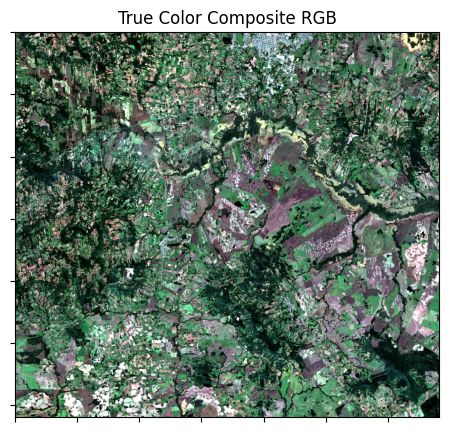

In [140]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(rgb_arr)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("True Color Composite RGB")
plt.show()

#### Saving Data Locally

In [141]:
rgb_ds.rio.to_raster("output.tif")

#### _Cleaning Up_

In [142]:
os.remove("output.tif")